# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
#     model="microsoft/deberta-v3-large"
    model="anferico/bert-for-patents"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [3]:
CFG.epochs

4

In [4]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [5]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.9.1
Found existing installation: transformers 4.16.2
Uninstalling transformers-4.16.2:
  Successfully uninstalled transformers-4.16.2


Found existing installation: tokenizers 0.11.6
Uninstalling tokenizers-0.11.6:
  Successfully uninstalled tokenizers-0.11.6


Looking in links: ../input/pppm-pip-wheels
Processing /kaggle/input/pppm-pip-wheels/transformers-4.18.0-py3-none-any.whl
Processing /kaggle/input/pppm-pip-wheels/tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.1 requires transformers<4.17,>=4.1, but you have transformers 4.18.0 which is incompatible.


Looking in links: ../input/pppm-pip-wheels


tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [6]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [7]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [8]:
# ====================================================
# CPC Data 主要是为了将cpc的一些文本关联到现在的数据上
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'): # os.listdir() 方法用于返回指定的文件夹包含的文件或文件夹的名字的列表
        result = re.findall(pattern, file_name)  # 筛选英文字母和数字
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, []))) # sum([['a1'],['b2']],[])-> ['a1', 'b2']
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s) # ['A\t\tHUMAN NECESSITIES']
        cpc_result = result[0].lstrip(pattern)  # 'HUMAN NECESSITIES'
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+' # 'A01\t\t.+'
            result = re.findall(pattern, s)  #['A01\t\tAGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTING; TRAPPING; FISHING']
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [9]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

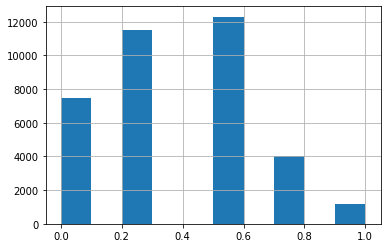

In [10]:
train['score'].hist()

In [11]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [12]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [13]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [14]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/322k [00:00<?, ?B/s]

In [15]:
CFG.tokenizer

PreTrainedTokenizerFast(name_or_path='anferico/bert-for-patents', vocab_size=39859, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

# Dataset

In [16]:
# ====================================================
# Define max_len 主要为了计算拼接后文本的长度
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])  # 计算cpc_contexts文本的长度
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 117


In [17]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long) # 转成tensor
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [18]:

train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)


{'input_ids': tensor([    2, 35736,     3, 35736,  1662, 10461,     3,  2194, 26450,  7636,
         6112,  1017,  7055,  1030,  4633,  4455,  1695, 22114,  1030,  3822,
         6006,  1030, 17353,  6006,  1030, 29970, 35225,  1664,  1901,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# Model

In [19]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  #last_hidden_states: torch.Size([16, 133, 1024])
#         print('last_hidden_states:',last_hidden_states.shape)
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)  # weights: torch.Size([16, 133, 1])
#         print('weights:',weights.shape)
        feature = torch.sum(weights * last_hidden_states, dim=1)  #[16,1024] attention
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):  # criterion是loss-func
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)  #混合精度训练 通过放大loss的值来防止梯度的underflow
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)  # 将tensor转到device中
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):  #混合精度训练
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))  # 计算loss
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:  # 梯度叠加 即多个batch后再更新梯度
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)  # 模型产出
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [21]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):  #folds代表df的数据集 fold是验证集
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [22]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1709] Elapsed 0m 2s (remain 65m 49s) Loss: 0.8368(0.8368) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 1m 11s (remain 19m 0s) Loss: 0.8237(0.6779) Grad: 102999.9141  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 2m 21s (remain 17m 38s) Loss: 0.6949(0.6572) Grad: 94624.1641  LR: 0.00001996  
Epoch: [1][300/1709] Elapsed 3m 30s (remain 16m 24s) Loss: 0.6342(0.6386) Grad: 52136.0000  LR: 0.00001990  
Epoch: [1][400/1709] Elapsed 4m 39s (remain 15m 12s) Loss: 0.7253(0.6256) Grad: 81838.2109  LR: 0.00001983  
Epoch: [1][500/1709] Elapsed 5m 49s (remain 14m 1s) Loss: 0.6644(0.6157) Grad: 61319.2344  LR: 0.00001974  
Epoch: [1][600/1709] Elapsed 6m 58s (remain 12m 51s) Loss: 0.3648(0.6060) Grad: 39084.3047  LR: 0.00001962  
Epoch: [1][700/1709] Elapsed 8m 7s (remain 11m 41s) Loss: 0.5729(0.6002) Grad: 44979.0352  LR: 0.00001949  
Epoch: [1][800/1709] Elapsed 9m 17s (remain 10m 31s) Loss: 0.5370(0.5940) Grad: 95381.9453  LR: 0.00001933  
Epoch: [1][900/1709] Elapsed 10

Epoch 1 - avg_train_loss: 0.5731  avg_val_loss: 0.5422  time: 1314s
Epoch 1 - Score: 0.8284
Epoch 1 - Save Best Score: 0.8284 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.5138(0.5422) 
Epoch: [2][0/1709] Elapsed 0m 1s (remain 30m 45s) Loss: 0.6286(0.6286) Grad: 148213.0312  LR: 0.00001707  
Epoch: [2][100/1709] Elapsed 1m 10s (remain 18m 42s) Loss: 0.5520(0.5276) Grad: 62371.4180  LR: 0.00001674  
Epoch: [2][200/1709] Elapsed 2m 19s (remain 17m 28s) Loss: 0.5783(0.5295) Grad: 65343.6367  LR: 0.00001639  
Epoch: [2][300/1709] Elapsed 3m 29s (remain 16m 18s) Loss: 0.4796(0.5274) Grad: 75252.0078  LR: 0.00001603  
Epoch: [2][400/1709] Elapsed 4m 38s (remain 15m 8s) Loss: 0.5645(0.5277) Grad: 52801.0742  LR: 0.00001566  
Epoch: [2][500/1709] Elapsed 5m 47s (remain 13m 58s) Loss: 0.3845(0.5277) Grad: 63530.9883  LR: 0.00001527  
Epoch: [2][600/1709] Elapsed 6m 57s (remain 12m 49s) Loss: 0.3964(0.5266) Grad: 24672.4043  LR: 0.00001488  
Epoch: [2][700/1709] Elapsed 8m 6s (remain 11m 39s) Loss: 0.5553(0.5265) Grad: 63985.3438  LR: 0.00001447  
Epoch: [2][800/1709] Elapsed 9m 15s (remain 10m 30s) Loss: 0.4427

Epoch 2 - avg_train_loss: 0.5212  avg_val_loss: 0.5358  time: 1312s
Epoch 2 - Score: 0.8499
Epoch 2 - Save Best Score: 0.8499 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4914(0.5358) 
Epoch: [3][0/1709] Elapsed 0m 0s (remain 27m 52s) Loss: 0.5004(0.5004) Grad: 104390.1406  LR: 0.00001000  
Epoch: [3][100/1709] Elapsed 1m 10s (remain 18m 39s) Loss: 0.5542(0.5049) Grad: 174019.4844  LR: 0.00000954  
Epoch: [3][200/1709] Elapsed 2m 19s (remain 17m 27s) Loss: 0.5062(0.5056) Grad: 54059.3398  LR: 0.00000908  
Epoch: [3][300/1709] Elapsed 3m 28s (remain 16m 17s) Loss: 0.5345(0.5065) Grad: 48818.3672  LR: 0.00000863  
Epoch: [3][400/1709] Elapsed 4m 38s (remain 15m 8s) Loss: 0.6097(0.5070) Grad: 62525.3281  LR: 0.00000817  
Epoch: [3][500/1709] Elapsed 5m 47s (remain 13m 58s) Loss: 0.5092(0.5048) Grad: 49825.7305  LR: 0.00000772  
Epoch: [3][600/1709] Elapsed 6m 57s (remain 12m 49s) Loss: 0.6017(0.5044) Grad: 70581.9688  LR: 0.00000728  
Epoch: [3][700/1709] Elapsed 8m 6s (remain 11m 39s) Loss: 0.5267(0.5021) Grad: 72065.9922  LR: 0.00000684  
Epoch: [3][800/1709] Elapsed 9m 16s (remain 10m 30s) Loss: 0.535

Epoch 3 - avg_train_loss: 0.5024  avg_val_loss: 0.5428  time: 1313s
Epoch 3 - Score: 0.8558
Epoch 3 - Save Best Score: 0.8558 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4871(0.5428) 
Epoch: [4][0/1709] Elapsed 0m 0s (remain 26m 35s) Loss: 0.4894(0.4894) Grad: 36630.6836  LR: 0.00000293  
Epoch: [4][100/1709] Elapsed 1m 10s (remain 18m 40s) Loss: 0.4097(0.5024) Grad: 53605.0625  LR: 0.00000261  
Epoch: [4][200/1709] Elapsed 2m 19s (remain 17m 28s) Loss: 0.5242(0.5037) Grad: 70330.9453  LR: 0.00000231  
Epoch: [4][300/1709] Elapsed 3m 29s (remain 16m 18s) Loss: 0.5647(0.4993) Grad: 58632.5352  LR: 0.00000203  
Epoch: [4][400/1709] Elapsed 4m 38s (remain 15m 8s) Loss: 0.5878(0.4972) Grad: 74456.2031  LR: 0.00000176  
Epoch: [4][500/1709] Elapsed 5m 47s (remain 13m 58s) Loss: 0.4496(0.4957) Grad: 76557.1562  LR: 0.00000151  
Epoch: [4][600/1709] Elapsed 6m 57s (remain 12m 49s) Loss: 0.4073(0.4969) Grad: 67211.9219  LR: 0.00000127  
Epoch: [4][700/1709] Elapsed 8m 6s (remain 11m 39s) Loss: 0.4467(0.4973) Grad: 68010.4141  LR: 0.00000106  
Epoch: [4][800/1709] Elapsed 9m 16s (remain 10m 30s) Loss: 0.4824(

Epoch 4 - avg_train_loss: 0.4959  avg_val_loss: 0.5434  time: 1313s
Epoch 4 - Score: 0.8567
Epoch 4 - Save Best Score: 0.8567 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4849(0.5434) 


========== fold: 0 result ==========
Score: 0.8567
========== fold: 1 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1709] Elapsed 0m 0s (remain 24m 10s) Loss: 0.6869(0.6869) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 1m 10s (remain 18m 36s) Loss: 0.6098(0.6749) Grad: 70548.5078  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 2m 19s (remain 17m 25s) Loss: 0.3670(0.6495) Grad: 21442.5586  LR: 0.00001996  
Epoch: [1][300/1709] Elapsed 3m 28s (remain 16m 16s) Loss: 0.5793(0.6371) Grad: 37944.4023  LR: 0.00001990  
Epoch: [1][400/1709] Elapsed 4m 38s (remain 15m 7s) Loss: 0.4917(0.6228) Grad: 18527.5488  LR: 0.00001983  
Epoch: [1][500/1709] Elapsed 5m 47s (remain 13m 57s) Loss: 0.5404(0.6128) Grad: 21492.4375  LR: 0.00001974  
Epoch: [1][600/1709] Elapsed 6m 56s (remain 12m 48s) Loss: 0.5785(0.6049) Grad: 28074.8066  LR: 0.00001962  
Epoch: [1][700/1709] Elapsed 8m 6s (remain 11m 39s) Loss: 0.6241(0.5998) Grad: 28864.0273  LR: 0.00001949  
Epoch: [1][800/1709] Elapsed 9m 15s (remain 10m 29s) Loss: 0.5022(0.5945) Grad: 17522.7754  LR: 0.00001933  
Epoch: [1][900/1709] Elapsed 10

Epoch 1 - avg_train_loss: 0.5730  avg_val_loss: 0.5466  time: 1312s
Epoch 1 - Score: 0.8263
Epoch 1 - Save Best Score: 0.8263 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4591(0.5466) 
Epoch: [2][0/1709] Elapsed 0m 1s (remain 29m 21s) Loss: 0.4440(0.4440) Grad: 95399.5391  LR: 0.00001707  
Epoch: [2][100/1709] Elapsed 1m 10s (remain 18m 39s) Loss: 0.5479(0.5211) Grad: 35395.4922  LR: 0.00001674  
Epoch: [2][200/1709] Elapsed 2m 19s (remain 17m 27s) Loss: 0.5513(0.5175) Grad: 36827.6797  LR: 0.00001639  
Epoch: [2][300/1709] Elapsed 3m 28s (remain 16m 17s) Loss: 0.5163(0.5180) Grad: 37577.1719  LR: 0.00001603  
Epoch: [2][400/1709] Elapsed 4m 38s (remain 15m 7s) Loss: 0.5718(0.5202) Grad: 44294.1602  LR: 0.00001566  
Epoch: [2][500/1709] Elapsed 5m 47s (remain 13m 58s) Loss: 0.5128(0.5209) Grad: 56453.8945  LR: 0.00001527  
Epoch: [2][600/1709] Elapsed 6m 57s (remain 12m 48s) Loss: 0.5774(0.5210) Grad: 12651.3730  LR: 0.00001488  
Epoch: [2][700/1709] Elapsed 8m 6s (remain 11m 39s) Loss: 0.6570(0.5223) Grad: 52852.6289  LR: 0.00001447  
Epoch: [2][800/1709] Elapsed 9m 15s (remain 10m 30s) Loss: 0.5098(

Epoch 2 - avg_train_loss: 0.5207  avg_val_loss: 0.5383  time: 1313s
Epoch 2 - Score: 0.8513
Epoch 2 - Save Best Score: 0.8513 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.3817(0.5383) 
Epoch: [3][0/1709] Elapsed 0m 0s (remain 27m 15s) Loss: 0.3315(0.3315) Grad: 49016.7031  LR: 0.00001000  
Epoch: [3][100/1709] Elapsed 1m 10s (remain 18m 39s) Loss: 0.4822(0.4965) Grad: 32411.8691  LR: 0.00000954  
Epoch: [3][200/1709] Elapsed 2m 19s (remain 17m 27s) Loss: 0.4176(0.4972) Grad: 20231.8574  LR: 0.00000908  
Epoch: [3][300/1709] Elapsed 3m 28s (remain 16m 17s) Loss: 0.5142(0.4970) Grad: 23698.7109  LR: 0.00000863  
Epoch: [3][400/1709] Elapsed 4m 38s (remain 15m 7s) Loss: 0.3600(0.4998) Grad: 46756.4414  LR: 0.00000817  
Epoch: [3][500/1709] Elapsed 5m 47s (remain 13m 58s) Loss: 0.4386(0.5005) Grad: 26930.0508  LR: 0.00000772  
Epoch: [3][600/1709] Elapsed 6m 57s (remain 12m 48s) Loss: 0.5112(0.5015) Grad: 44843.0664  LR: 0.00000728  
Epoch: [3][700/1709] Elapsed 8m 6s (remain 11m 39s) Loss: 0.5738(0.5027) Grad: 71624.9922  LR: 0.00000684  
Epoch: [3][800/1709] Elapsed 9m 15s (remain 10m 30s) Loss: 0.4443(

Epoch 3 - avg_train_loss: 0.5018  avg_val_loss: 0.5445  time: 1313s
Epoch 3 - Score: 0.8574
Epoch 3 - Save Best Score: 0.8574 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.3758(0.5445) 
Epoch: [4][0/1709] Elapsed 0m 0s (remain 27m 8s) Loss: 0.5517(0.5517) Grad: 41324.2461  LR: 0.00000293  
Epoch: [4][100/1709] Elapsed 1m 10s (remain 18m 42s) Loss: 0.5340(0.4912) Grad: 85324.3359  LR: 0.00000261  
Epoch: [4][200/1709] Elapsed 2m 20s (remain 17m 30s) Loss: 0.4035(0.4984) Grad: 66495.5312  LR: 0.00000231  
Epoch: [4][300/1709] Elapsed 3m 29s (remain 16m 20s) Loss: 0.5114(0.4951) Grad: 61723.5820  LR: 0.00000203  
Epoch: [4][400/1709] Elapsed 4m 38s (remain 15m 9s) Loss: 0.4035(0.4964) Grad: 49938.7500  LR: 0.00000176  
Epoch: [4][500/1709] Elapsed 5m 48s (remain 13m 59s) Loss: 0.5286(0.4958) Grad: 82246.5859  LR: 0.00000151  
Epoch: [4][600/1709] Elapsed 6m 57s (remain 12m 50s) Loss: 0.5043(0.4964) Grad: 69389.3750  LR: 0.00000127  
Epoch: [4][700/1709] Elapsed 8m 7s (remain 11m 40s) Loss: 0.4685(0.4949) Grad: 94417.8672  LR: 0.00000106  
Epoch: [4][800/1709] Elapsed 9m 16s (remain 10m 31s) Loss: 0.5769(0

Epoch 4 - avg_train_loss: 0.4945  avg_val_loss: 0.5488  time: 1314s
Epoch 4 - Score: 0.8574


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.3778(0.5488) 


========== fold: 1 result ==========
Score: 0.8574
========== fold: 2 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1709] Elapsed 0m 0s (remain 25m 52s) Loss: 0.6745(0.6745) Grad: 388875.7188  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 1m 10s (remain 18m 38s) Loss: 0.6087(0.6648) Grad: 82249.7109  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 2m 19s (remain 17m 28s) Loss: 0.4889(0.6455) Grad: 81786.5312  LR: 0.00001996  
Epoch: [1][300/1709] Elapsed 3m 29s (remain 16m 19s) Loss: 0.6704(0.6315) Grad: 56176.0586  LR: 0.00001990  
Epoch: [1][400/1709] Elapsed 4m 38s (remain 15m 9s) Loss: 0.7417(0.6188) Grad: 109263.1094  LR: 0.00001983  
Epoch: [1][500/1709] Elapsed 5m 48s (remain 13m 59s) Loss: 0.6078(0.6112) Grad: 23285.5078  LR: 0.00001974  
Epoch: [1][600/1709] Elapsed 6m 57s (remain 12m 50s) Loss: 0.5442(0.6058) Grad: 35282.2227  LR: 0.00001962  
Epoch: [1][700/1709] Elapsed 8m 7s (remain 11m 40s) Loss: 0.5811(0.6014) Grad: 48537.5469  LR: 0.00001949  
Epoch: [1][800/1709] Elapsed 9m 16s (remain 10m 30s) Loss: 0.5244(0.5959) Grad: 68670.7969  LR: 0.00001933  
Epoch: [1][900/1709] E

Epoch 1 - avg_train_loss: 0.5778  avg_val_loss: 0.5413  time: 1314s
Epoch 1 - Score: 0.8268
Epoch 1 - Save Best Score: 0.8268 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4533(0.5413) 
Epoch: [2][0/1709] Elapsed 0m 1s (remain 29m 13s) Loss: 0.6539(0.6539) Grad: 197647.5469  LR: 0.00001707  
Epoch: [2][100/1709] Elapsed 1m 10s (remain 18m 45s) Loss: 0.4812(0.5326) Grad: 380334.4688  LR: 0.00001674  
Epoch: [2][200/1709] Elapsed 2m 20s (remain 17m 31s) Loss: 0.5878(0.5370) Grad: 230954.6406  LR: 0.00001639  
Epoch: [2][300/1709] Elapsed 3m 29s (remain 16m 19s) Loss: 0.5138(0.5314) Grad: 61860.6914  LR: 0.00001603  
Epoch: [2][400/1709] Elapsed 4m 38s (remain 15m 9s) Loss: 0.6307(0.5296) Grad: 94258.8594  LR: 0.00001566  
Epoch: [2][500/1709] Elapsed 5m 48s (remain 13m 59s) Loss: 0.7046(0.5296) Grad: 606295.5625  LR: 0.00001527  
Epoch: [2][600/1709] Elapsed 6m 57s (remain 12m 49s) Loss: 0.5725(0.5302) Grad: 100441.8047  LR: 0.00001488  
Epoch: [2][700/1709] Elapsed 8m 7s (remain 11m 40s) Loss: 0.4389(0.5294) Grad: 19853.0938  LR: 0.00001447  
Epoch: [2][800/1709] Elapsed 9m 16s (remain 10m 30s) Loss: 0.

Epoch 2 - avg_train_loss: 0.5257  avg_val_loss: 0.5395  time: 1314s
Epoch 2 - Score: 0.8433
Epoch 2 - Save Best Score: 0.8433 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4434(0.5395) 
Epoch: [3][0/1709] Elapsed 0m 1s (remain 29m 58s) Loss: 0.5261(0.5261) Grad: 133018.6406  LR: 0.00001000  
Epoch: [3][100/1709] Elapsed 1m 10s (remain 18m 42s) Loss: 0.4720(0.5075) Grad: 28517.2852  LR: 0.00000954  
Epoch: [3][200/1709] Elapsed 2m 19s (remain 17m 29s) Loss: 0.4850(0.5090) Grad: 44154.9062  LR: 0.00000908  
Epoch: [3][300/1709] Elapsed 3m 29s (remain 16m 19s) Loss: 0.6484(0.5083) Grad: 430484.1250  LR: 0.00000863  
Epoch: [3][400/1709] Elapsed 4m 38s (remain 15m 8s) Loss: 0.4556(0.5108) Grad: 119657.5156  LR: 0.00000817  
Epoch: [3][500/1709] Elapsed 5m 47s (remain 13m 58s) Loss: 0.6033(0.5101) Grad: 248314.5625  LR: 0.00000772  
Epoch: [3][600/1709] Elapsed 6m 57s (remain 12m 49s) Loss: 0.5384(0.5084) Grad: 1329310.7500  LR: 0.00000728  
Epoch: [3][700/1709] Elapsed 8m 6s (remain 11m 39s) Loss: 0.5541(0.5101) Grad: 81052.6406  LR: 0.00000684  
Epoch: [3][800/1709] Elapsed 9m 15s (remain 10m 30s) Loss: 0

Epoch 3 - avg_train_loss: 0.5100  avg_val_loss: 0.5463  time: 1313s
Epoch 3 - Score: 0.8477
Epoch 3 - Save Best Score: 0.8477 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4711(0.5463) 
Epoch: [4][0/1709] Elapsed 0m 0s (remain 27m 46s) Loss: 0.5466(0.5466) Grad: 49593.7812  LR: 0.00000293  
Epoch: [4][100/1709] Elapsed 1m 10s (remain 18m 39s) Loss: 0.5092(0.5067) Grad: 41508.6133  LR: 0.00000261  
Epoch: [4][200/1709] Elapsed 2m 19s (remain 17m 28s) Loss: 0.5315(0.5018) Grad: 45549.0742  LR: 0.00000231  
Epoch: [4][300/1709] Elapsed 3m 29s (remain 16m 18s) Loss: 0.5155(0.5037) Grad: 135032.0781  LR: 0.00000203  
Epoch: [4][400/1709] Elapsed 4m 38s (remain 15m 8s) Loss: 0.4902(0.5037) Grad: 66496.8750  LR: 0.00000176  
Epoch: [4][500/1709] Elapsed 5m 47s (remain 13m 59s) Loss: 0.5183(0.5035) Grad: 39011.1367  LR: 0.00000151  
Epoch: [4][600/1709] Elapsed 6m 57s (remain 12m 49s) Loss: 0.4590(0.5038) Grad: 32934.6523  LR: 0.00000127  
Epoch: [4][700/1709] Elapsed 8m 6s (remain 11m 39s) Loss: 0.5671(0.5038) Grad: 38415.8789  LR: 0.00000106  
Epoch: [4][800/1709] Elapsed 9m 16s (remain 10m 30s) Loss: 0.4206

Epoch 4 - avg_train_loss: 0.5023  avg_val_loss: 0.5490  time: 1313s
Epoch 4 - Score: 0.8494
Epoch 4 - Save Best Score: 0.8494 Model
========== fold: 2 result ==========
Score: 0.8494
========== fold: 3 training ==========
Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly 

Epoch: [1][0/1709] Elapsed 0m 0s (remain 24m 48s) Loss: 0.7594(0.7594) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 1m 10s (remain 18m 35s) Loss: 0.6915(0.6611) Grad: 64853.5742  LR: 0.00001999  
Epoch: [1][200/1709] Elapsed 2m 19s (remain 17m 26s) Loss: 0.6633(0.6454) Grad: 22142.2188  LR: 0.00001996  
Epoch: [1][300/1709] Elapsed 3m 28s (remain 16m 17s) Loss: 0.6876(0.6355) Grad: 34269.7383  LR: 0.00001990  
Epoch: [1][400/1709] Elapsed 4m 38s (remain 15m 7s) Loss: 0.5390(0.6249) Grad: 31932.5488  LR: 0.00001983  
Epoch: [1][500/1709] Elapsed 5m 47s (remain 13m 57s) Loss: 0.5462(0.6164) Grad: 16784.6387  LR: 0.00001974  
Epoch: [1][600/1709] Elapsed 6m 56s (remain 12m 48s) Loss: 0.5697(0.6092) Grad: 24303.8613  LR: 0.00001962  
Epoch: [1][700/1709] Elapsed 8m 6s (remain 11m 38s) Loss: 0.5368(0.6029) Grad: 35266.5547  LR: 0.00001949  
Epoch: [1][800/1709] Elapsed 9m 15s (remain 10m 29s) Loss: 0.5235(0.5998) Grad: 10917.9424  LR: 0.00001933  
Epoch: [1][900/1709] Elapsed 10

Epoch 1 - avg_train_loss: 0.5774  avg_val_loss: 0.5405  time: 1312s
Epoch 1 - Score: 0.8255
Epoch 1 - Save Best Score: 0.8255 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4440(0.5405) 
Epoch: [2][0/1709] Elapsed 0m 1s (remain 31m 34s) Loss: 0.4558(0.4558) Grad: 83629.5547  LR: 0.00001707  
Epoch: [2][100/1709] Elapsed 1m 10s (remain 18m 42s) Loss: 0.4633(0.5159) Grad: 52465.7266  LR: 0.00001674  
Epoch: [2][200/1709] Elapsed 2m 19s (remain 17m 29s) Loss: 0.5715(0.5204) Grad: 21122.0195  LR: 0.00001639  
Epoch: [2][300/1709] Elapsed 3m 29s (remain 16m 19s) Loss: 0.4424(0.5251) Grad: 39653.7070  LR: 0.00001603  
Epoch: [2][400/1709] Elapsed 4m 38s (remain 15m 9s) Loss: 0.4685(0.5262) Grad: 59881.7617  LR: 0.00001566  
Epoch: [2][500/1709] Elapsed 5m 48s (remain 13m 59s) Loss: 0.5913(0.5259) Grad: 50069.6836  LR: 0.00001527  
Epoch: [2][600/1709] Elapsed 6m 57s (remain 12m 50s) Loss: 0.6138(0.5261) Grad: 40880.0781  LR: 0.00001488  
Epoch: [2][700/1709] Elapsed 8m 7s (remain 11m 40s) Loss: 0.5685(0.5249) Grad: 36099.6562  LR: 0.00001447  
Epoch: [2][800/1709] Elapsed 9m 16s (remain 10m 30s) Loss: 0.5324(

Epoch 2 - avg_train_loss: 0.5211  avg_val_loss: 0.5433  time: 1314s
Epoch 2 - Score: 0.8410
Epoch 2 - Save Best Score: 0.8410 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4601(0.5433) 
Epoch: [3][0/1709] Elapsed 0m 0s (remain 26m 45s) Loss: 0.4930(0.4930) Grad: 52294.2852  LR: 0.00001000  
Epoch: [3][100/1709] Elapsed 1m 10s (remain 18m 39s) Loss: 0.4868(0.5083) Grad: 33453.1445  LR: 0.00000954  
Epoch: [3][200/1709] Elapsed 2m 19s (remain 17m 28s) Loss: 0.5745(0.5009) Grad: 27640.0859  LR: 0.00000908  
Epoch: [3][300/1709] Elapsed 3m 29s (remain 16m 18s) Loss: 0.5938(0.5043) Grad: 28488.3750  LR: 0.00000863  
Epoch: [3][400/1709] Elapsed 4m 38s (remain 15m 8s) Loss: 0.4975(0.5069) Grad: 53649.8242  LR: 0.00000817  
Epoch: [3][500/1709] Elapsed 5m 48s (remain 13m 59s) Loss: 0.5487(0.5088) Grad: 43626.7383  LR: 0.00000772  
Epoch: [3][600/1709] Elapsed 6m 57s (remain 12m 49s) Loss: 0.4582(0.5079) Grad: 23857.0000  LR: 0.00000728  
Epoch: [3][700/1709] Elapsed 8m 7s (remain 11m 40s) Loss: 0.5828(0.5074) Grad: 17678.7285  LR: 0.00000684  
Epoch: [3][800/1709] Elapsed 9m 16s (remain 10m 30s) Loss: 0.5249(

Epoch 3 - avg_train_loss: 0.5063  avg_val_loss: 0.5487  time: 1314s
Epoch 3 - Score: 0.8478
Epoch 3 - Save Best Score: 0.8478 Model


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4374(0.5487) 
Epoch: [4][0/1709] Elapsed 0m 0s (remain 26m 44s) Loss: 0.4695(0.4695) Grad: 35369.2109  LR: 0.00000293  
Epoch: [4][100/1709] Elapsed 1m 10s (remain 18m 41s) Loss: 0.6161(0.4953) Grad: 99476.6641  LR: 0.00000261  
Epoch: [4][200/1709] Elapsed 2m 20s (remain 17m 30s) Loss: 0.4508(0.4969) Grad: 24668.9023  LR: 0.00000231  
Epoch: [4][300/1709] Elapsed 3m 29s (remain 16m 20s) Loss: 0.4851(0.4959) Grad: 128472.8594  LR: 0.00000203  
Epoch: [4][400/1709] Elapsed 4m 39s (remain 15m 10s) Loss: 0.4930(0.4957) Grad: 27955.6113  LR: 0.00000176  
Epoch: [4][500/1709] Elapsed 5m 48s (remain 14m 0s) Loss: 0.4972(0.4969) Grad: 21388.9004  LR: 0.00000151  
Epoch: [4][600/1709] Elapsed 6m 58s (remain 12m 50s) Loss: 0.4629(0.4976) Grad: 42234.5000  LR: 0.00000127  
Epoch: [4][700/1709] Elapsed 8m 7s (remain 11m 41s) Loss: 0.3961(0.4995) Grad: 50127.9727  LR: 0.00000106  
Epoch: [4][800/1709] Elapsed 9m 17s (remain 10m 31s) Loss: 0.5612

Epoch 4 - avg_train_loss: 0.4989  avg_val_loss: 0.5497  time: 1314s
Epoch 4 - Score: 0.8472


EVAL: [569/570] Elapsed 2m 6s (remain 0m 0s) Loss: 0.4458(0.5497) 


========== fold: 3 result ==========
Score: 0.8478
========== CV ==========
Score: 0.8523


[fold0] avg_train_loss,█▃▂▁
[fold0] avg_val_loss,▇▁▇█
[fold0] epoch,▁▃▆█
[fold0] loss,█▇▄▄▅▃▄▄▄▆▃▄▅▄▃▃▅▂▅▂▆▂▅▃▃▅▃▅▄▂▄▃▄▂▃▁▃▄▅▃
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▆██
[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,▇▁▅█
[fold1] epoch,▁▃▆█
[fold1] loss,▆█▄▇▆▆▅▅▅▆▃▃▆▄▃▄▅▃▄▁▄▃▃▆▄▄▄▄▅▄▃▄▄▃▅▃▂▄▄▁
[fold1] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
